In [55]:
import torch
from torch.utils.data import DataLoader, RandomSampler
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

random_seed = 17283

In [13]:
def download_qqd_data(random_seed):

    qqp_data = load_dataset("glue","qqp")
    qqp_train_splitted = qqp_data["train"].train_test_split(test_size=0.2,seed=random_seed,stratify_by_column="label")
    qqp_val_splitted = qqp_data["validation"].train_test_split(test_size=0.2,seed=random_seed,stratify_by_column="label")

    data = {
        "training": DatasetDict({
            "train": qqp_train_splitted["train"],
            "validation": qqp_train_splitted["test"],
            "test": qqp_data["test"]
        }),
        "calibration": DatasetDict({
            "train": qqp_val_splitted["train"],
            "validation": qqp_val_splitted["test"],
            "test": deepcopy(qqp_data["test"])
        })
    }
    return data

def create_tokenizer():
    return AutoTokenizer.from_pretrained("bert-base-uncased")

def create_dataloaders(datasets,tokenizer,random_seed=0,batch_size=32):

    def apply_encoding(tokenizer,sample):
        return tokenizer(
            text=sample["question1"],
            text_pair=sample["question2"],
            padding="do_not_pad",
            truncation=True,
            max_length=256,
        )

    def data_collator(tokenizer,features):
        return tokenizer.pad(
            features,
            padding="longest",
            max_length=None,
            pad_to_multiple_of=None,
            return_tensors="pt",
        )

    generator = torch.Generator()
    generator.manual_seed(int(random_seed))

    dataloaders = {}
    for name, dataset in datasets.items():
        if not isinstance(dataset.features["label"],ClassLabel):
            dataset = dataset.class_encode_column("label")
        dataset = dataset.map(
            lambda sample: apply_encoding(tokenizer,sample),
            batched=True,
            batch_size=512,
            remove_columns=[column for column in dataset.column_names if column not in ["input_ids","attention_mask","token_type_ids","label"]]
        )
        dataloaders[name] = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=False,
            sampler=RandomSampler(dataset,num_samples=len(dataset),generator=generator),
            num_workers=8,
            collate_fn=lambda features: data_collator(tokenizer,features)
        )

    return dataloaders


data = download_qqd_data(random_seed)
tokenizer = create_tokenizer()
dataloaders = create_dataloaders(data["training"],tokenizer,random_seed=0,batch_size=32)

Found cached dataset glue (/home/lestienne/.cache/huggingface/datasets/glue/qqp/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached split indices for dataset at /home/lestienne/.cache/huggingface/datasets/glue/qqp/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-087f7b863a619629.arrow and /home/lestienne/.cache/huggingface/datasets/glue/qqp/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-bcfd9d7760ac776b.arrow
Loading cached split indices for dataset at /home/lestienne/.cache/huggingface/datasets/glue/qqp/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-66c4bebe9ed69451.arrow and /home/lestienne/.cache/huggingface/datasets/glue/qqp/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-1f16b6c43125cf85.arrow


  0%|          | 0/569 [00:00<?, ?ba/s]

  0%|          | 0/143 [00:00<?, ?ba/s]

  0%|          | 0/764 [00:00<?, ?ba/s]

In [64]:
import os
import torch.nn as nn

class CBOW(nn.Module):

    def __init__(self,tokenizer,hidden_size,output_size):
        super().__init__()
        num_embeddings = len(tokenizer)
        self.linear_input = nn.Embedding(
            num_embeddings=num_embeddings,
            embedding_dim=hidden_size,
            padding_idx=tokenizer.pad_token_id
        )
        self.linear_output = nn.Linear(in_features=hidden_size,out_features=output_size)

    def forward(self,input_ids,token_type_ids,attention_mask):
        x = self.linear_input(input_ids).mean(dim=1)
        x = torch.relu(x)
        logits = self.linear_output(x)
        return {"logits": logits}



model_name = "cbow"
if model_name == "cbow":
    model = CBOW(tokenizer,hidden_size=400,output_size=1)
elif model_name == "bert":
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=1)
results_dir = f"../results/{model_name}/run00_0/07_Train model/version_0/checkpoints"
state_dict = torch.load(os.path.join(results_dir,os.listdir(results_dir)[0]))["state_dict"]
model.load_state_dict({
    key.split("model.")[-1]: state_dict[f"{key}"] for key in state_dict.keys()
})
model
model.eval()

CBOW(
  (linear_input): Embedding(30522, 400, padding_idx=0)
  (linear_output): Linear(in_features=400, out_features=1, bias=True)
)

In [69]:
from tqdm import tqdm

results = {}
for split, dataloader in dataloaders.items():
    all_labels = []
    all_logits = []
    print(split)
    for batch in tqdm(dataloader):
        labels = batch.pop("label").view(-1)
        all_labels.append(labels)
        with torch.no_grad():
            logits = model(**batch)["logits"].view(-1)
            all_logits.append(logits)
    all_labels = torch.cat(all_labels).numpy()
    all_logits = torch.cat(all_logits).numpy()
    results[split] = {
        "labels": all_labels,
        "logits": all_logits
    }

import pickle
with open(f"../{model_name}_results.pkl","wb") as f:
    pickle.dump(results,f)

train


  0%|          | 0/9097 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `_

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|█████████▉| 9084/9097 [00:11<00:00, 833.49it/s]

	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 9097/9097 [00:11<00:00, 802.36it/s]


validation


  0%|          | 0/2275 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `_

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 97%|█████████▋| 2208/2275 [00:03<00:00, 837.30it/s]

	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 2275/2275 [00:03<00:00, 699.13it/s]


test


  0%|          | 0/12218 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `_

	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 12218/12218 [00:15<00:00, 811.85it/s]


In [68]:
results

{'train': {'labels': array([1, 1, 0, ..., 0, 1, 0]),
  'logits': array([ -0.47506553,  -1.0199497 ,  -1.951016  , ..., -14.371104  ,
           0.94091755,  -5.0620985 ], dtype=float32)},
 'validation': {'labels': array([0, 0, 0, ..., 1, 0, 0]),
  'logits': array([-5.366811 , -2.6259027, -1.871501 , ..., -1.1364172, -5.1908154,
         -2.0357196], dtype=float32)},
 'test': {'labels': array([-1, -1, -1, ..., -1, -1, -1]),
  'logits': array([-0.9306036 , -0.04512712,  1.8851213 , ..., -3.499448  ,
         -2.3883498 , -4.3523874 ], dtype=float32)}}

In [62]:
accuracy = np.mean(all_labels == all_predictions)
accuracy


0.8662635701525354

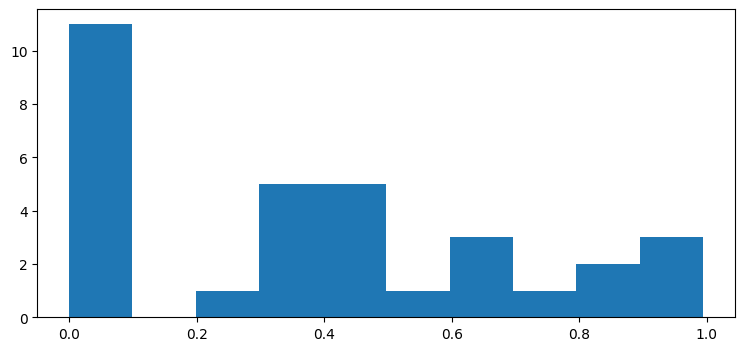

In [50]:
fig, ax = plt.subplots(1,1,figsize=(9,4))
ax.hist(torch.sigmoid(logits.view(-1)),bins=10);
